In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import roc_auc_score as ras
import warnings
warnings.filterwarnings('ignore')

In [71]:
df = pd.read_csv('Parkinsons_data.csv')
df.shape

(195, 24)

In [72]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [73]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


Data Cleaning

In [74]:
df = df.groupby('name').mean().reset_index()
df.drop('name', axis=1, inplace=True)

In [75]:
columns = list(df.columns)
for col in columns:
    if col == 'status':
        continue
 
    filtered_columns = [col]
    for col1 in df.columns:
        if((col == col1) | (col == 'status')):
            continue
 
        val = df[col].corr(df[col1])
 
        if val > 0.7:
            # If the correlation between the two
            # features is more than 0.7 remove
            columns.remove(col1)
            continue
        else:
            filtered_columns.append(col1)
 
    # After each iteration filter out the columns
    # which are not highly correlated features.
    df = df[filtered_columns]
df.shape

(195, 11)

In [76]:
X = df.drop('status', axis=1)
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=10)
selector.fit(X_norm, df['status'])
filtered_columns = selector.get_support()
filtered_data = X.loc[:, filtered_columns]
filtered_data['status'] = df['status']
df = filtered_data
df.shape

(195, 11)

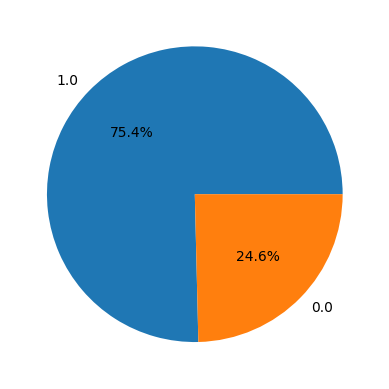

In [77]:
x = df['status'].value_counts()
plt.pie(x.values,
        labels = x.index,
        autopct='%1.1f%%')
plt.show()

In [78]:
features = df.drop('status', axis=1)
target = df['status']
 
X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.2,
                                      random_state=42)
X_train.shape, X_val.shape

((156, 10), (39, 10))

In [79]:
# As the data was highly imbalanced we will balance
#it by adding repetitive rows of minority class.
ros = RandomOverSampler(sampling_strategy='minority',
                        random_state=42)
X, Y = ros.fit_resample(X_train, Y_train)
X.shape, Y.shape

((230, 10), (230,))

XG_Boost

In [80]:
models = XGBClassifier()
 

models.fit(X, Y)
 
print(f'{models} : ')
 
train_preds = models.predict_proba(X)[:, 1]
print('Training Accuracy : ', ras(Y, train_preds))
 
val_preds = models.predict_proba(X_val)[:, 1]
print('Validation Accuracy : ', ras(Y_val, val_preds))
print()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.9375



Support Vector Classifier (SVC)

In [81]:
classifi2 = SVC()
classifi2.fit(X,Y)
y2_pred = classifi2.predict(X_val)
print(accuracy_score(Y_val, y2_pred)*100, "%")


66.66666666666666 %


In [82]:
pd.DataFrame(

confusion_matrix(Y_val, y2_pred),

columns=['Predicted Healthy', 'Predicted Parkinsons'],

index=['True Healthy', 'True Parkinsons']

)


,Predicted Healthy,Predicted Parkinsons
True Healthy,3,4
True Parkinsons,9,23
